In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit import RDPaths
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import numpy as np
import pandas as pd
from IPython.display import HTML

RDKit WARNING: [11:24:44] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
traindf = PandasTools.LoadSDF(os.path.join(RDPaths.RDDocsDir,'Book/data/solubility.train.sdf'))
testdf = PandasTools.LoadSDF(os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.test.sdf'))

,ID,NAME,SOL,SOL_classification,smiles,ROMol
0,n-pentane,n-pentane,-3.18,(A) low,CCCCC,
1,cyclopentane,cyclopentane,-2.64,(B) medium,C1CCCC1,

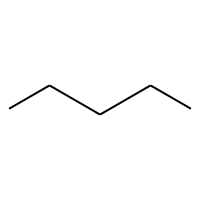
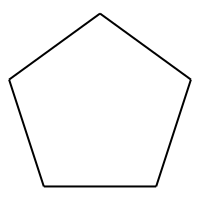

In [3]:
HTML(traindf.head(2).to_html())

In [4]:
cls2lab = {'(A) low':0, '(B) medium':1, '(C) high':2}

In [5]:
def fp2np(fp):
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [6]:
trainfp = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in traindf.ROMol]
testfp =  [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in testdf.ROMol]

In [7]:
trainX = np.array([fp2np(fp) for fp in trainfp])
testX = np.array([fp2np(fp) for fp in testfp])

In [8]:
trainY = np.array([cls2lab[i] for i in traindf.SOL_classification.to_list()])
testY =  np.array([cls2lab[i] for i in testdf.SOL_classification.to_list()])

In [9]:
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import SVR, SVC

[MLENS] backend: threading


## Base model

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=794)
rf.fit(trainX, trainY)
pred = rf.predict(testX)
accuracy_score(testY, pred)

0.7198443579766537

## SuperLearner is stacking model

In [11]:
ensemble = SuperLearner(scorer=accuracy_score, random_state=794, verbose=2)
ensemble.add([RandomForestClassifier(n_estimators=100, random_state=794), SVC(gamma='auto', C=1000)])
ensemble.add_meta(LogisticRegression(solver='lbfgs', multi_class='auto'))


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=3251, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...81782f0>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=794, sample_size=20,
       scorer=<function accuracy_score at 0x7f61481782f0>, shuffle=False,
       verbose=2)

In [12]:
ensemble.fit(trainX, trainY)
pred = ensemble.predict(testX)
accuracy_score(testY, pred)


Fitting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:01

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


0.7159533073929961

In [13]:
ensemble.data

                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  randomforestclassifier       0.55     0.01  0.37  0.01  0.03  0.00
layer-1  svc                          0.56     0.03  0.60  0.10  0.40  0.02

## Blending approaches

In [14]:
from mlens.ensemble import BlendEnsemble

In [15]:
ensemble2 = BlendEnsemble(scorer=accuracy_score, test_size=0.2, verbose=2)
ensemble2.add([RandomForestClassifier(n_estimators=794, random_state=794),
                 SVC(gamma='auto')])
ensemble2.add_meta(LogisticRegression(solver='lbfgs', multi_class='auto'))

BlendEnsemble(array_check=None, backend=None,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=BlendIndex(X=None, raise_on_exception=...81782f0>)],
   n_jobs=-1, name='group-3', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function accuracy_score at 0x7f61481782f0>, shuffle=False,
       test_size=0.2, verbose=2)

In [16]:
ensemble2.fit(trainX, trainY)


Fitting 2 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:03


BlendEnsemble(array_check=None, backend=None,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=BlendIndex(X=None, raise_on_exception=...81782f0>)],
   n_jobs=-1, name='group-3', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function accuracy_score at 0x7f61481782f0>, shuffle=False,
       test_size=0.2, verbose=2)

In [17]:
pred_b = ensemble2.predict(testX)


Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [18]:
ensemble2.data

                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  randomforestclassifier       0.60     0.00  3.21  0.00  0.08  0.00
layer-1  svc                          0.38     0.00  1.72  0.00  0.39  0.00

In [19]:
accuracy_score(pred_b, testY)

0.669260700389105